In [19]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import scipy.io
from torchvision import transforms, utils
import os
from PIL import Image

In [20]:
class GravityDataset(Dataset):
    def __init__(self, folder, image_size, exts=['mat']):
        super().__init__()
        self.folder = folder
        self.image_size = image_size
        self.paths = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.mat')]

        # Define transformations that are independent of scaling
        self.transform = transforms.Compose([
            transforms.Resize((int(image_size * 1.12), int(image_size * 1.12))),  # Resize slightly larger
            transforms.RandomCrop(image_size),  # Then crop to the target size
            transforms.RandomHorizontalFlip(),  # Random horizontal flip
            transforms.ToTensor()  # Convert to tensor
        ])

    def scale_to_minus1_1(self, tensor):
        """Dynamically scale the tensor to the range [-1, 1] based on its own min and max values."""
        min_val = tensor.min()
        max_val = tensor.max()
        # Avoid division by zero if min and max are the same
        if max_val > min_val:
            return 2 * ((tensor - min_val) / (max_val - min_val)) - 1
        else:
            return tensor  # If min and max are the same, return tensor as is.
        # tensor = tensor
        return tensor  # If min and max are the same, return tensor as is.

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        file_path = self.paths[index]
        # Load the .mat file
        data_loc = scipy.io.loadmat(file_path)
        data_val = data_loc['d']

        data_val = data_val.reshape(32, 32)
        # Convert numpy array as a PIL image
        img = Image.fromarray(data_val)

        # Apply transformations
        if self.transform:
            img = self.transform(img)
        
        # Scale the image to [-1, 1] based on its own min and max values
        img = self.scale_to_minus1_1(img)
        return img

In [21]:
data = '/mnt/drive/adarsh/DC_cold3/Experiment-14/neg_int'
dataset = GravityDataset(data, image_size=32)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

In [22]:
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", use_safetensors=True)
pipeline.unet.config["in_channels"]
4

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 28.56it/s]


4

**Training Configuration**

In [23]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 32  # the generated image resolution
    train_batch_size = 32
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_model_id = "jainadarsh/trial"  # the name of the repository to create on the HF Hub
    hub_private_repo = None
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

**Load Dataset**

In [74]:
# from datasets import load_dataset

# config.dataset_name = "huggan/smithsonian_butterflies_subset"
# dataset = load_dataset(config.dataset_name, split="train")

data = '/mnt/drive/adarsh/DC_cold3/Experiment-14/neg_int'
dataset = GravityDataset(data, image_size=32)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

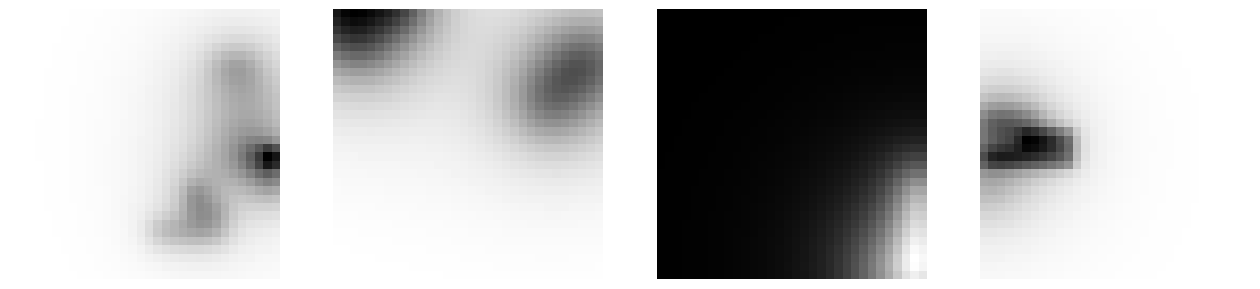

In [75]:
import matplotlib.pyplot as plt
import torch

batch = next(iter(dataloader))  # batch shape (B, C, H, W)
imgs = batch[:4]                # take first 4

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, img in enumerate(imgs):
    img = img.detach().cpu()
    if img.ndim == 3:                # (C,H,W) -> (H,W,C)
        img = img.permute(1, 2, 0)
    img = (img + 1) / 2              # convert from [-1,1] to [0,1]
    arr = img.numpy().squeeze()
    axs[i].imshow(arr, cmap='gray' if arr.ndim == 2 else None)
    axs[i].axis('off')
plt.show()

**Create a Architecture**

In [76]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [77]:
sample_image = dataset.__getitem__(0).unsqueeze(0)  # add batch dimension
print("Input shape:", sample_image.shape)
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 1, 32, 32])
Output shape: torch.Size([1, 1, 32, 32])


**Create a scheduler**

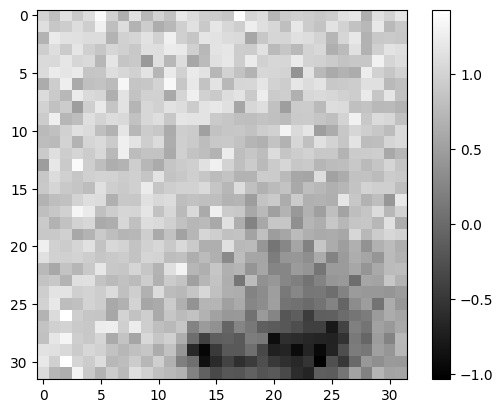

In [78]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps = 1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])  # example timestep
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

# print("Noisy image shape:", noisy_image.shape)
# Image.fromarray(noisy_image.numpy().squeeze())
plt.imshow(noisy_image.detach().cpu().numpy().squeeze(), cmap='gray')
plt.colorbar()
# plt.axis('off')
plt.show()


In [79]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

**Train the model**

In [80]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [81]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [85]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

In [86]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [88]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


/mnt/drive/adarsh/DC_cold3/my-env/lib/python3.12/site-packages/accelerate/accelerator.py:529: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
Epoch 0:   0%|          | 0/344 [00:00<?, ?it/s]/tmp/ipykernel_288020/2880730127.py:33: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  clean_images = batch["images"]


IndexError: too many indices for tensor of dimension 4